In [1]:
import stim
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sinter
from mec import make_circle
from typing import List
import pymatching
import galois
from collections import Counter

In [2]:

# code = [15,3,11,0,1,0,13,2]
# code = [15,3,11,2,0,0,11,13]
# code = [15,3,12,2,1,1,3,7]
code = [3,15,12,1,2,0,14,1,3,15,2,4]


In [3]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[1]
m = code[0]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)

In [4]:
def par2gen(H):
    GF = galois.GF(2)
    gfH = GF(H)
    gfH_rank = np.linalg.matrix_rank(gfH)

    rref_H = gfH.row_reduce()

    swaps = []
    col_H = rref_H.copy()
    for i in range(gfH_rank):
        inds = np.where(col_H[i])[0]
        pivot = inds[0]
        col_H[:,[i,pivot]] = col_H[:,[pivot,i]]
        swaps.append((i,pivot))

    col_H = col_H[:gfH_rank]
    col_G = GF(np.hstack([col_H[:,gfH_rank:].T, np.eye(H.shape[1]-gfH_rank, dtype=int)]))

    G = col_G.copy()
    for swap in swaps[::-1]:
        G[:,[swap[1],swap[0]]] = G[:,[swap[0],swap[1]]]

    if (np.any(G @ rref_H[:gfH_rank].T) or np.any(col_G @ col_H.T)):
        print("FAILED")
        return
    return (np.array(G, dtype=int), np.array(col_G, dtype=int))

def commute(x, z, n):
    # 0 if commute, 1 if anticommute
    x1 = x[:n]
    x2 = x[n:]
    z1 = z[:n]
    z2 = z[n:]
    return (x1 @ z2 % 2) ^ (x2 @ z1 % 2)
    

def SGSOP(Gx, Gz, n):
    # symplectic gram-schmidt orthogonalization procedure
    sym_Gx = np.hstack([Gx, np.zeros(Gx.shape, dtype=int)])
    sym_Gz = np.hstack([np.zeros(Gz.shape, dtype=int), Gz])
    sym_G = np.vstack([sym_Gx, sym_Gz])
    logicals = []
    generators = []

    while(sym_G.shape[0]):
        g1 = sym_G[0]

        commutes = True
        for i in range(1, sym_G.shape[0]-1):
            g2 = sym_G[i]
            if (commute(g1,g2,n)):
                logicals.append((g1, g2))
                sym_G = np.delete(sym_G, [0, i], axis=0)

                for j in range(sym_G.shape[0]):
                    gj = sym_G[j]
                    sym_G[j] = gj ^ (commute(gj,g2,n) * g1) ^ (commute(gj,g1,n) * g2)
                commutes = False
                break
        
        if commutes:
            generators.append(g1)
            sym_G = np.delete(sym_G, 0, axis=0)
    
    return (logicals, generators)

In [5]:
def get_logicals(gen_type=False):
    n = Hx.shape[1]
    Gx, col_Gx = par2gen(Hx)
    Gz, col_Gz = par2gen(Hz)
    logicals, generators = SGSOP(Gx, Gz, n)

    logX = np.array([l[1][n:] for l in logicals])
    logZ = np.array([l[0][:n] for l in logicals])

    if gen_type: return logX
    else: return logZ

In [6]:
def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice

lattice = embed_code((code[8],code[9],code[10],code[11]), 0)

In [7]:
all_qbts = {}

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            all_qbts[(i,j)] = int(lattice[i][j][1:])
            qbts[int(lattice[i][j][1:])] = (i, j)
x_checks = np.array([None for i in range(m*ell)])
z_checks = np.array([None for i in range(m*ell)])

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            x_checks[int(lattice[i][j][1:])] = (i, j)
        elif lattice[i][j][0] == "z":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            z_checks[int(lattice[i][j][1:])-(m*ell)] = (i, j)

x_rs = []
z_rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs.append(make_circle(gen_qbts)[2])

lr_x_checks = []
sr_x_checks = []
lr_z_checks = []
sr_z_checks = []

for i, x_check in enumerate(x_checks):
    gen_qbts = qbts[np.where(Hx[i])[0]]

    nonlocal_qbts = []
    if (x_rs[i] > (min(x_rs)+np.std(x_rs))):
        lr_x_checks.append(i)
    else:
        sr_x_checks.append(i)

for i, z_check in enumerate(z_checks):
    gen_qbts = qbts[np.where(Hz[i])[0]]

    nonlocal_qbts = []
    if (z_rs[i] > min(z_rs)+np.std(z_rs)):
        lr_z_checks.append(i)
    else:
        sr_z_checks.append(i)

In [8]:
def get_ancilla_allocations():
    gens = []
    for i, x in enumerate(lr_x_checks):
        x_check = x_checks[x]
        gen_qbts = qbts[np.where(Hx[x])[0]]

        nonlocal_qbts = []
        for qbt in gen_qbts:
            if (abs(qbt[0] - x_check[0]) + abs(qbt[1] - x_check[1])) > 2*m:
                nonlocal_qbts.append(qbt)
        gens.append([nonlocal_qbts, x_checks[x]])
        
    for i, z in enumerate(lr_z_checks):
        z_check = z_checks[z]
        gen_qbts = qbts[np.where(Hz[z])[0]]

        nonlocal_qbts = []
        for qbt in gen_qbts:
            if (abs(qbt[0] - z_check[0]) + abs(qbt[1] - z_check[1])) > 2*m:
                nonlocal_qbts.append(qbt)
        gens.append([nonlocal_qbts, z_checks[z]])

    anc_alloc = {}
    for gen in gens:
        anc_alloc[gen[1]] = len(gen[0])
    c = Counter(list(itertools.chain(*[gen[0] for gen in gens])))
    for qbt, anc in c.items():
        anc_alloc[qbt] = anc
    
    return anc_alloc

In [9]:
def lr_bell_pair(paths):
    size = len(path)
    c = stim.Circuit()

    for path in paths:
        c.append("H", path[:-1][::2])

    c.append("CNOT", path[:size-(size%2)])
    c.append("TICK")
    c.append("CNOT", path[1:size-1+(size%2)])

    c.append("H", path[:-1][1::2])
    c.append("MR", path[1:-1])

    for i in range(2 - (size%2), size-1, 2):
        c.append("CZ", [stim.target_rec(-i), path[0]])
    for i in range(1 + (size%2), size-1, 2):
        c.append("CX", [stim.target_rec(-i), path[-1]])
    
    return c

def lr_CNOT_bell(control, target, bell_pair):
    c = stim.Circuit()

    c.append("TICK")
    c.append("CNOT", [control, bell_pair[0], bell_pair[1], target])
    c.append("MR", bell_pair[0])
    c.append("MRX", bell_pair[1])
    c.append("CX", [stim.target_rec(-2), target])
    c.append("CZ", [stim.target_rec(-1), control])

    return c

def lr_CNOT_no_bell(paths):
    # path[0] is control, path[-1] is target. Reverse path to get reverse CNOT
    c = stim.Circuit()
    
    for path in paths:
        size = len(path)
        c.append("H", path[:-1][2::2])
        # c.append("DEPOLARIZE1", path[:-1][2::2], 0.001)
    c.append("TICK")

    for path in paths:
        size = len(path)
        c.append("CNOT", path[:size-(size%2)])
        c.append("DEPOLARIZE2", path[:size-(size%2)], 0.001)
    c.append("TICK")

    for path in paths:
        size = len(path)
        c.append("CNOT", path[1:size-1+(size%2)])
        c.append("DEPOLARIZE2", path[1:size-1+(size%2)], 0.001)
    c.append("TICK")
    
    for path in paths:
        c.append("H", path[:-1][1::2])
        # c.append("DEPOLARIZE1", path[:-1][2::2], 0.001)
    c.append("TICK")

    for path in paths:
        c.append("MR", path[1:-1])
    c.append("TICK")

    # for j, path in enumerate(paths):
    #     size = len(path)
    #     for i in range(2 - (size%2), size-1, 2):
    #         c.append("CZ", [stim.target_rec(-(size-2)*(num_paths-1-j)-i), path[0]])
    #         # c.append("CZ", [stim.target_rec(-i), path[0]])
    #     for i in range(1 + (size%2), size-1, 2):
    #         c.append("CX", [stim.target_rec(-(size-2)*(num_paths-1-j)-i), path[-1]])
    #         # c.append("CX", [stim.target_rec(-i), path[-1]])
    # c.append("TICK")

    for j, path in enumerate(paths):
        tot_len = sum([len(p[1:-1]) for p in paths[j:]])
        size = len(path)
        for i in range(1 + (size%2), size-1, 2):
            c.append("CZ", [stim.target_rec(-tot_len+i-1), path[0]])
            # c.append("CZ", [stim.target_rec(-i), path[0]])
        for i in range(2 - (size%2), size-1, 2):
            c.append("CX", [stim.target_rec(-tot_len+i-1), path[-1]])
            # c.append("CX", [stim.target_rec(-i), path[-1]])
    c.append("TICK")

    return c

In [174]:
def sr_x_up_right(gen_index):
    x_checks_i = [x for x in sr_x_checks if ((x_checks[x][1]//2)%3==gen_index)]
    x_paths = [[(x_checks[x][0], x_checks[x][1])]+[(x_checks[x][0]+1, x_checks[x][1]-i) for i in range(5)] for x in x_checks_i]
    return x_paths

def sr_x_up(gen_index):
    x_checks_i = [x for x in sr_x_checks if ((x_checks[x][1]//2)%3==gen_index)]
    x_paths = [[(x_checks[x][0], x_checks[x][1]-i) for i in range(4)] for x in x_checks_i]
    return x_paths

def sr_x_left():
    x_checks_i = [x for x in sr_x_checks if (x_checks[x][0]==0)]
    x_paths = [[(x_checks[x][0]+i, x_checks[x][1]) for i in range(6)] for x in x_checks_i]
    return x_paths

def sr_z_down_left(gen_index):
    z_checks_i = [z for z in sr_z_checks if ((z_checks[z][1]//2)%3==gen_index)]
    z_paths = [[(z_checks[z][0]-1, z_checks[z][1]+i) for i in range(5)][::-1]+[(z_checks[z][0], z_checks[z][1])] for z in z_checks_i]
    return z_paths

def sr_z_down(gen_index):
    z_checks_i = [z for z in sr_z_checks if ((z_checks[z][1]//2)%3==gen_index)]
    z_paths = [[(z_checks[z][0], z_checks[z][1]+i) for i in range(4)][::-1] for z in z_checks_i]
    return z_paths

def sr_z_right():
    z_checks_i = [z for z in sr_z_checks if (z_checks[z][0]==5)]
    z_paths = [[(z_checks[z][0]-i, z_checks[z][1]) for i in range(6)][::-1] for z in z_checks_i]
    return z_paths

# -------------------------------------------------------------------

def lr_x_down(gen_index): # 0 or 1
    x_checks_i = [x for x in lr_x_checks if ((x_checks[x][1]//2)%3)==gen_index]
    x_paths = [[(x_checks[x][0], x_checks[x][1]+i) for i in range(28)] for x in x_checks_i]
    return x_paths

def lr_x_down_right(gen_index): # 0 or 1
    x_checks_i = [x for x in lr_x_checks if ((x_checks[x][1]//2)%3)==gen_index]
    x_paths = [[(x_checks[x][0], x_checks[x][1])]+[(x_checks[x][0]+1, x_checks[x][1]+i) for i in range(27)] for x in x_checks_i]
    return x_paths

def lr_x_up_down(gen_index=0): # only 0
    x_checks_i = [x for x in lr_x_checks if ((x_checks[x][1]//2)%3)==gen_index]
    x_paths = [[(x_checks[x][0], x_checks[x][1]+i) for i in range(30)] for x in x_checks_i]
    return x_paths

def lr_x_left():
    x_checks_i = [x for x in lr_x_checks if (x_checks[x][0]==0)]
    x_paths = [[(x_checks[x][0]+i, x_checks[x][1]) for i in range(6)] for x in x_checks_i]
    return x_paths

def lr_z_down_up(gen_index=2): # only 2
    z_checks_i = [z for z in lr_z_checks if ((z_checks[z][1]//2)%3)==gen_index]
    z_paths = [[(z_checks[z][0], z_checks[z][1]-i) for i in range(30)][::-1] for z in z_checks_i]
    return z_paths

def lr_z_up(gen_index): # 1 or 2
    z_checks_i = [z for z in lr_z_checks if ((z_checks[z][1]//2)%3)==gen_index]
    z_paths = [[(z_checks[z][0], z_checks[z][1]-i) for i in range(28)][::-1] for z in z_checks_i]
    return z_paths

def lr_z_up_left(gen_index): # 1 or 2
    z_checks_i = [z for z in lr_z_checks if ((z_checks[z][1]//2)%3)==gen_index]
    z_paths = [[(z_checks[z][0]-1, z_checks[z][1]-i) for i in range(27)][::-1]+[(z_checks[z][0], z_checks[z][1])] for z in z_checks_i]
    return z_paths

def lr_z_right():
    z_checks_i = [z for z in lr_z_checks if (z_checks[z][0]==5)]
    z_paths = [[(z_checks[z][0]-i, z_checks[z][1]) for i in range(6)][::-1] for z in z_checks_i]
    return z_paths

# --------------------------------------------------------------------

def xz_down(checks):
    c = stim.Circuit()
    path_qbts = []
    for x_check in checks[0]:
        pos = x_checks[x_check]
        if (pos[1] < 2*ell-1): 
            path_qbts += [all_qbts[x_checks[x_check]], all_qbts[(pos[0], pos[1]+1)]]
    for z_check in checks[1]:
        pos = z_checks[z_check]
        if (pos[1] < 2*ell-1): 
            path_qbts += [all_qbts[(pos[0], pos[1]+1)], all_qbts[z_checks[z_check]]]
    c.append("CNOT", path_qbts)
    c.append("DEPOLARIZE2", path_qbts, 0.001)
    c.append("TICK")
    return c

def xz_right(checks):
    c = stim.Circuit()
    path_qbts = []
    for x_check in checks[0]:
        pos = x_checks[x_check]
        if (pos[0] > 0): 
            path_qbts += [all_qbts[x_checks[x_check]], all_qbts[(pos[0]-1, pos[1])]]
    for z_check in checks[1]:
        pos = z_checks[z_check]
        if (pos[0] > 0): 
            path_qbts += [all_qbts[(pos[0]-1, pos[1])], all_qbts[z_checks[z_check]]]
    c.append("CNOT", path_qbts)
    c.append("DEPOLARIZE2", path_qbts, 0.001)
    c.append("TICK")
    return c

def xz_left(checks):
    c = stim.Circuit()
    path_qbts = []
    for x_check in checks[0]:
        pos = x_checks[x_check]
        if (pos[0] < 2*m-1): 
            path_qbts += [all_qbts[x_checks[x_check]], all_qbts[(pos[0]+1, pos[1])]]
    for z_check in checks[1]:
        pos = z_checks[z_check]
        if (pos[0] < 2*m-1): 
            path_qbts += [all_qbts[(pos[0]+1, pos[1])], all_qbts[z_checks[z_check]]]
    c.append("CNOT", path_qbts)
    c.append("DEPOLARIZE2", path_qbts, 0.001)
    c.append("TICK")
    return c

def xz_up(checks):
    c = stim.Circuit()
    path_qbts = []
    for x_check in checks[0]:
        pos = x_checks[x_check]
        if (pos[1] > 0): 
            path_qbts += [all_qbts[x_checks[x_check]], all_qbts[(pos[0], pos[1]-1)]]
    for z_check in checks[1]:
        pos = z_checks[z_check]
        if (pos[1] > 0): 
            path_qbts += [all_qbts[(pos[0], pos[1]-1)], all_qbts[z_checks[z_check]]]
    c.append("CNOT", path_qbts)
    c.append("DEPOLARIZE2", path_qbts, 0.001)
    c.append("TICK")
    return c

# ---------------------------------------------------------------------


def direct_CNOT(paths):
    c = stim.Circuit()
    qbt_paths = []
    for path in paths:
        qbt_paths += [all_qbts[path[0]], all_qbts[path[-1]]]
    c.append("CNOT", qbt_paths)
    c.append("DEPOLARIZE2", qbt_paths, 0.001)
    c.append("TICK")
    return c

def bell_CNOT(paths):
    c = stim.Circuit()
    path_qbts = []
    for path in paths:
        path_qbts.append([all_qbts[qbt] + 4*m*ell if 0 < i < len(path)-1 else all_qbts[qbt] for i, qbt in enumerate(path)])
    c += lr_CNOT_no_bell(path_qbts)
    return c

In [181]:
def sr_z_down(gen_index, mod, col_ind):
    z_checks_i = [z for z in sr_z_checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 == col_ind)]
    z_paths = [[(z_checks[z][0], z_checks[z][1]+i) for i in range(4)][::-1] for z in z_checks_i]
    return z_paths

def sr_z_down_right(gen_index, mod, col_ind):
    z_checks_i = [z for z in sr_z_checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 == col_ind)]
    z_paths = [[(z_checks[z][0]+i, z_checks[z][1]+6) for i in range(4)][::-1]+[(z_checks[z][0], z_checks[z][1]+i) for i in range(7)][::-1] for z in z_checks_i]
    return z_paths

def sr_z_down_left(gen_index, mod, col_ind):
    z_checks_i = [z for z in sr_z_checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 == col_ind)]
    z_paths = [[(z_checks[z][0]-i, z_checks[z][1]+6) for i in range(4)][::-1]+[(z_checks[z][0], z_checks[z][1]+i) for i in range(7)][::-1] for z in z_checks_i]
    return z_paths

def sr_z_down_local(gen_index, mod, col_ind):
    z_checks_i = [z for z in sr_z_checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 == col_ind)]
    z_paths = [[(z_checks[z][0], z_checks[z][1]+i) for i in range(2)][::-1] for z in z_checks_i]
    return z_paths

def sr_z_left_local(gen_index, mod, col_ind):
    z_checks_i = [z for z in sr_z_checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 == col_ind)]
    z_paths = [[(z_checks[z][0]-i, z_checks[z][1]) for i in range(2)][::-1] for z in z_checks_i]
    return z_paths

def sr_z_up_local(gen_index, mod, col_ind):
    z_checks_i = [z for z in sr_z_checks if ((z_checks[z][1]//2)%mod==gen_index) and (z_checks[z][0]//2 == col_ind)]
    z_paths = [[(z_checks[z][0], z_checks[z][1]-i) for i in range(2)][::-1] for z in z_checks_i]
    return z_paths



c = stim.Circuit()

for key, value in all_qbts.items():
    c.append("QUBIT_COORDS", value, (key[0],key[1],0))
    # c.append("QUBIT_COORDS", value+(4*m*ell), (key[0],key[1],1))
    
c += direct_CNOT(sr_z_down_left(0,3,2) + sr_z_down_left(2,3,1)
                 + sr_z_down(1,3,2) + sr_z_down(0,3,1) + sr_z_down(0,3,0)
                 + sr_z_down_local(2,3,0)
                 + sr_z_left_local(1,3,0))
c += direct_CNOT(sr_z_down_left(1,3,2) + sr_z_down_left(0,3,1)
                 + sr_z_down(2,3,2) + sr_z_down(1,3,1) + sr_z_down(1,3,0) 
                 + sr_z_down_local(0,3,0)
                 + sr_z_left_local(2,3,0))
c += direct_CNOT(sr_z_down_left(2,3,2) + sr_z_down_left(1,3,1)
                 + sr_z_down(0,3,2) + sr_z_down(2,3,1) + sr_z_down(2,3,0)
                 + sr_z_down_local(1,3,0)
                 + sr_z_left_local(0,3,0))


# c += direct_CNOT(sr_z_down_right(0,2,0) + sr_z_down_right(1,2,0))
# c += direct_CNOT(sr_z_down_right(1) + sr_z_down(0,4,0) + sr_z_down(1,2,2) + sr_z_down(1,3,1))
# c += direct_CNOT(sr_z_down_right(1) + sr_z_down(0,2,0) + sr_z_down(1,2,2) + sr_z_down(2,4,1))
# c += direct_CNOT(sr_z_down_right(1) + sr_z_down(0,2,0) + sr_z_down(1,2,2) + sr_z_down(3,4,1))

# c += direct_CNOT(sr_z_down_right(0) + sr_z_down(0, 2, 2) + sr_z_down(1, 2, 0) + sr_z_down(1, 4, 1))

# c += direct_CNOT(sr_z_down_left(0,2,2) + sr_z_down_left(1,2,1) + sr_z_down(1,4,0)) # + sr_z_down(2,4,1))
c += direct_CNOT(sr_z_down_right(0,2,0)
                 + sr_z_down_local(1,2,0) + sr_z_down_local(1,2,1) + sr_z_down_local(1,2,2) 
                 + sr_z_left_local(0,2,1) + sr_z_left_local(0,2,2))
c += direct_CNOT(sr_z_down_right(1,2,0) 
                 + sr_z_down_local(0,2,0) + sr_z_down_local(0,2,1) + sr_z_down_local(0,2,2)
                 + sr_z_left_local(1,2,1) + sr_z_left_local(1,2,2))

with open("tmp.svg", "w") as f:
    f.write(str(c.without_noise().diagram("timeslice-svg")))
print(c.without_noise())

QUBIT_COORDS(0, 1, 0) 48
QUBIT_COORDS(0, 3, 0) 51
QUBIT_COORDS(0, 5, 0) 54
QUBIT_COORDS(0, 7, 0) 57
QUBIT_COORDS(0, 9, 0) 60
QUBIT_COORDS(0, 11, 0) 63
QUBIT_COORDS(0, 13, 0) 66
QUBIT_COORDS(0, 15, 0) 69
QUBIT_COORDS(0, 17, 0) 72
QUBIT_COORDS(0, 19, 0) 75
QUBIT_COORDS(0, 21, 0) 78
QUBIT_COORDS(0, 23, 0) 81
QUBIT_COORDS(0, 25, 0) 84
QUBIT_COORDS(0, 27, 0) 87
QUBIT_COORDS(0, 29, 0) 45
QUBIT_COORDS(1, 0, 0) 2
QUBIT_COORDS(1, 2, 0) 5
QUBIT_COORDS(1, 4, 0) 8
QUBIT_COORDS(1, 6, 0) 11
QUBIT_COORDS(1, 8, 0) 14
QUBIT_COORDS(1, 10, 0) 17
QUBIT_COORDS(1, 12, 0) 20
QUBIT_COORDS(1, 14, 0) 23
QUBIT_COORDS(1, 16, 0) 26
QUBIT_COORDS(1, 18, 0) 29
QUBIT_COORDS(1, 20, 0) 32
QUBIT_COORDS(1, 22, 0) 35
QUBIT_COORDS(1, 24, 0) 38
QUBIT_COORDS(1, 26, 0) 41
QUBIT_COORDS(1, 28, 0) 44
QUBIT_COORDS(2, 1, 0) 49
QUBIT_COORDS(2, 3, 0) 52
QUBIT_COORDS(2, 5, 0) 55
QUBIT_COORDS(2, 7, 0) 58
QUBIT_COORDS(2, 9, 0) 61
QUBIT_COORDS(2, 11, 0) 64
QUBIT_COORDS(2, 13, 0) 67
QUBIT_COORDS(2, 15, 0) 70
QUBIT_COORDS(2, 17, 0) 73
QUBI

In [67]:
def sr_checks():
    c = stim.Circuit()
    c.append("H", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks])
    c.append("TICK")

    c += direct_CNOT(sr_z_down_left(0)+sr_z_down(1))
    c += direct_CNOT(sr_z_down_left(1)+sr_z_down(2))
    c += direct_CNOT(sr_z_down_left(2)+sr_z_down(0))

    c += xz_down((sr_x_checks, sr_z_checks))
    c += xz_right((sr_x_checks, sr_z_checks))
    c += direct_CNOT(sr_z_right()+sr_x_left()) # crossing the short lattice dim
    # c += bell_CNOT(sr_z_right()+sr_x_left())
    c += xz_left((sr_x_checks, sr_z_checks))
    c += xz_up((sr_x_checks, sr_z_checks))

    c += direct_CNOT(sr_x_up_right(0)+sr_x_up(2))
    c += direct_CNOT(sr_x_up_right(1)+sr_x_up(0))
    c += direct_CNOT(sr_x_up_right(2)+sr_x_up(1))

    c.append("H", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks])
    c.append("TICK")

    return c


def all_checks():
    c = stim.Circuit()
    c.append("H", [all_qbts[x_check] for x_check in x_checks])
    c.append("TICK")

    c += direct_CNOT(sr_z_down_left(0)+sr_z_down(1))
    c += direct_CNOT(sr_z_down_left(1)+sr_z_down(2))
    c += direct_CNOT(sr_z_down_left(2)+sr_z_down(0))
    c += direct_CNOT(lr_z_up_left(2)+lr_z_up(1))
    c += direct_CNOT(lr_z_up_left(1))
    c += direct_CNOT(lr_z_up(2))    

    c += xz_down((sr_x_checks+lr_x_checks, sr_z_checks+lr_z_checks))
    c += direct_CNOT(lr_z_down_up())
    c += xz_right((sr_x_checks+lr_x_checks, sr_z_checks+lr_z_checks))
    c += direct_CNOT(sr_z_right()+sr_x_left()+lr_z_right()+lr_x_left())
    c += xz_left((sr_x_checks+lr_x_checks, sr_z_checks+lr_z_checks))
    c += direct_CNOT(lr_x_up_down())
    c += xz_up((sr_x_checks+lr_x_checks, sr_z_checks+lr_z_checks))

    c += direct_CNOT(sr_x_up_right(0)+sr_x_up(2))
    c += direct_CNOT(sr_x_up_right(1)+sr_x_up(0))
    c += direct_CNOT(sr_x_up_right(2)+sr_x_up(1))
    c += direct_CNOT(lr_x_down_right(0)+lr_x_down(1))
    c += direct_CNOT(lr_x_down_right(1))
    c += direct_CNOT(lr_x_down(0))

    c.append("H", [all_qbts[x_check] for x_check in x_checks])
    c.append("TICK")
    return c

In [68]:
def init_detectors():
    c = stim.Circuit()
    for i, z_check in enumerate(z_checks):
        coord = z_check
        c.append("DETECTOR", [stim.target_rec(-(m*ell)+i)], (coord[0], coord[1], 0))
    return c

def inter_detectors(meas_offset=0):
    c = stim.Circuit()
    c.append("SHIFT_COORDS", [], (0,0,1))
    # for i, x_check in enumerate(sr_x_checks+lr_x_checks):
    #     coord = x_checks[x_check]
    #     c.append("DETECTOR", [stim.target_rec(-(2*m*ell)+i), stim.target_rec(-(4*m*ell)-meas_offset+i)], (coord[0], coord[1], 0))
    for i, z_check in enumerate(z_checks):
        coord = z_check
        c.append("DETECTOR", [stim.target_rec(-(m*ell)+i), stim.target_rec(-(3*m*ell)-meas_offset+i)], (coord[0], coord[1], 0))
    return c

def observables():
    c = stim.Circuit()
    for i, logical in enumerate(get_logicals(False)):
        incl_qbts = np.where(logical)[0]
        incl_qbts = [-j-1 for j in incl_qbts]
        c.append("OBSERVABLE_INCLUDE", [stim.target_rec(j) for j in incl_qbts], i)
    return c

def final_detectors():
    c = stim.Circuit()
    for i, z_check in enumerate(z_checks):
        coord = z_check
        incl_qbts = np.where(Hz[i])[0]
        incl_qbts = [-j-1 for j in incl_qbts]
        c.append("DETECTOR", [stim.target_rec(-(3*m*ell)+i)]+[stim.target_rec(j) for j in incl_qbts], (coord[0], coord[1], 1))
    c += observables()
    return c

In [79]:
c = stim.Circuit()

for key, value in all_qbts.items():
    c.append("QUBIT_COORDS", value, (key[0],key[1],0))
    # c.append("QUBIT_COORDS", value+(4*m*ell), (key[0],key[1],1))
c.append("R", [qbt for qbt in all_qbts.values()])
# c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])
# c.append("TICK")


c += all_checks().without_noise()
# c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])
c.append("MR", [all_qbts[x_check] for x_check in x_checks])
c.append("MR", [all_qbts[z_check] for z_check in z_checks])
c += init_detectors()

c2 = stim.Circuit()
c2 += all_checks()
# c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])
c2.append("MR", [all_qbts[x_check] for x_check in x_checks])
c2.append("MR", [all_qbts[z_check] for z_check in z_checks])
# c2.append("TICK")
c2 += inter_detectors(0)

for i in range(10):
    c += c2

c += c2.without_noise()
# c += final_detectors()
c.append("M",[all_qbts[qbt] for qbt in qbts[::-1]])
c += observables()

# with open("tmp.svg", "w") as f:
#     f.write(str(c.without_noise().diagram("timeslice-svg")))
print(c)

QUBIT_COORDS(0, 1, 0) 45
QUBIT_COORDS(0, 3, 0) 51
QUBIT_COORDS(0, 5, 0) 57
QUBIT_COORDS(0, 7, 0) 63
QUBIT_COORDS(0, 9, 0) 69
QUBIT_COORDS(0, 11, 0) 75
QUBIT_COORDS(0, 13, 0) 81
QUBIT_COORDS(0, 15, 0) 87
QUBIT_COORDS(0, 17, 0) 48
QUBIT_COORDS(0, 19, 0) 54
QUBIT_COORDS(0, 21, 0) 60
QUBIT_COORDS(0, 23, 0) 66
QUBIT_COORDS(0, 25, 0) 72
QUBIT_COORDS(0, 27, 0) 78
QUBIT_COORDS(0, 29, 0) 84
QUBIT_COORDS(1, 0, 0) 0
QUBIT_COORDS(1, 2, 0) 6
QUBIT_COORDS(1, 4, 0) 12
QUBIT_COORDS(1, 6, 0) 18
QUBIT_COORDS(1, 8, 0) 24
QUBIT_COORDS(1, 10, 0) 30
QUBIT_COORDS(1, 12, 0) 36
QUBIT_COORDS(1, 14, 0) 42
QUBIT_COORDS(1, 16, 0) 3
QUBIT_COORDS(1, 18, 0) 9
QUBIT_COORDS(1, 20, 0) 15
QUBIT_COORDS(1, 22, 0) 21
QUBIT_COORDS(1, 24, 0) 27
QUBIT_COORDS(1, 26, 0) 33
QUBIT_COORDS(1, 28, 0) 39
QUBIT_COORDS(2, 1, 0) 46
QUBIT_COORDS(2, 3, 0) 52
QUBIT_COORDS(2, 5, 0) 58
QUBIT_COORDS(2, 7, 0) 64
QUBIT_COORDS(2, 9, 0) 70
QUBIT_COORDS(2, 11, 0) 76
QUBIT_COORDS(2, 13, 0) 82
QUBIT_COORDS(2, 15, 0) 88
QUBIT_COORDS(2, 17, 0) 49
QUBIT

In [80]:
np.set_printoptions(linewidth=200)
detector_sampler = c.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1, append_observables=True)[0]

for k in range(0, len(one_sample), 45):
    timeslice = one_sample[k:k+45]
    print("".join("!" if e else "_" for e in timeslice))

_____________________________________________
_____________________________________________
_____________________________________________
_____________________________________________
___!_________________________________!_______
____!________________________________________
______________________________________!______
__________________________!_____!____________
_____________________________________________
_____________________________________________
_____________________________________________
_____________________________________________
!!!!


In [81]:
from scipy.sparse import lil_matrix

dem = c.detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.uint8)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.uint8)

errors = []
channel_probs = [e.args_copy()[0] for e in c.detector_error_model() if e.type=="error"]
for i, error_event in enumerate(c.explain_detector_error_model_errors()):
    dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[dets],i] = 1
    lcm[[obs],i] = 1

print(pcm.shape)
print(lcm.shape)

(540, 4590)
(4, 4590)


In [85]:
from ldpc import bp_decoder, bposd_decoder

bp_dec = bp_decoder(
    pcm,
    channel_probs=channel_probs,
    max_iter=pcm.shape[1],
    bp_method="msl",
    ms_scaling_factor=0
)

bposd_dec = bposd_decoder(
    pcm, # the parity check matrix
    channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=pcm.shape[1], #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=min(pcm.shape[0],60) #the osd search depth
)

In [86]:
count = 0
num_iters = 1000

sampler = c.compile_detector_sampler()
for i in range(num_iters):
    detection_events, observable_flips = sampler.sample(1, separate_observables=True)
    # guessed_errors = bp_dec.decode(detection_events[0])
    guessed_errors = bposd_dec.decode(detection_events[0])
    guessed_obs = (lcm @ guessed_errors) % 2
    
    if not np.all(observable_flips[0].astype(int) == guessed_obs):
        count += 1
print(count/num_iters)

0.001


In [170]:
surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=r,
            distance=5,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': 5, 'r': r, 'p': noise},
    )
    # for d in [3, 5, 7]
    for r in [10,15,20,25,30]
    for noise in [0.001]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=5_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 4 workers...
5 cases left:
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=6,p=0.001,r=10}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=6,p=0.001,r=15}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=6,p=0.001,r=20}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=6,p=0.001,r=25}
5 cases left:
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=5000    {d=6,p=0.001,r=10}
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=5000    {d=6,p=0.001,r=15}
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=5000    {d=6,p=0.001,r=20}
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=5000    {d=6,p=0.001,r=25}
5 cases left:
    pymatching processes=1  ~core_mins_left=1940    shots_left=4999900  errors_left=5000    {d=6,p=0.001,r=10}
    pymatching processes=

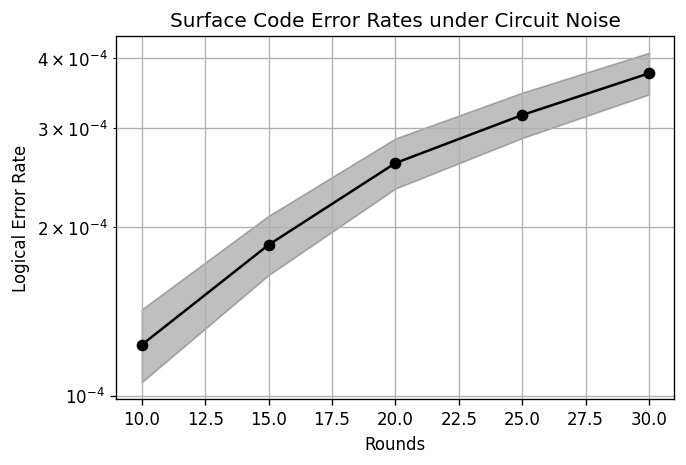

In [171]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['r'],
    # group_func=lambda stat: stat.json_metadata['d'],
    # failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
# ax.set_ylim(5e-3, 5e-2)
# ax.set_xlim(0.008, 0.012)
ax.semilogy()
ax.set_title("Surface Code Error Rates under Circuit Noise")
ax.set_xlabel("Rounds")
ax.set_ylabel("Logical Error Rate")
ax.grid(which='major')
ax.grid(which='minor')
# ax.legend()
fig.set_dpi(120)  # Show it bigger

In [172]:
collected_surface_code_stats

[sinter.TaskStats(strong_id='f69e56c78a00df8d431b53f6d2eddd11ac4139c2ac722be10c006f4a4459909b', decoder='pymatching', json_metadata={'d': 6, 'r': 10, 'p': 0.001}, shots=5000000, errors=616, seconds=23.07600000005914),
 sinter.TaskStats(strong_id='34fc6ba3abe8ee21c47513b71712f5dbab9785034231fef9d5e0b6db45d6f7d2', decoder='pymatching', json_metadata={'d': 6, 'r': 20, 'p': 0.001}, shots=5000000, errors=1300, seconds=45.73399999996764),
 sinter.TaskStats(strong_id='3de1d5e0bf44a6f86b5782420d7e048d00ad72426c89254c69c402dabde67760', decoder='pymatching', json_metadata={'d': 6, 'r': 15, 'p': 0.001}, shots=5000000, errors=929, seconds=34.655999999988126),
 sinter.TaskStats(strong_id='72c73ecc9cfc6031fd98a1e7ccf87645b3881c1c6b0e5b69a235dafea090a0c3', decoder='pymatching', json_metadata={'d': 6, 'r': 25, 'p': 0.001}, shots=5000000, errors=1584, seconds=53.562999999994645),
 sinter.TaskStats(strong_id='3af4a2040f1ed6a2feb8a7797e7306aaefffec67f0d787a6bf07b093a4ea7086', decoder='pymatching', json_m

In [173]:
1-(1-(1300/5000000))**8

0.0020781081839365

In [160]:
circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=20,
            distance=5,
            after_clifford_depolarization=0.001,
            after_reset_flip_probability=0.001,
            before_measure_flip_probability=0.001,
            before_round_data_depolarization=0.001,
        )
print(circuit)

QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(4, 0) 4
QUBIT_COORDS(5, 0) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 0) 7
QUBIT_COORDS(8, 0) 8
QUBIT_COORDS(0, 1) 9
QUBIT_COORDS(1, 1) 10
QUBIT_COORDS(2, 1) 11
QUBIT_COORDS(3, 1) 12
QUBIT_COORDS(4, 1) 13
QUBIT_COORDS(5, 1) 14
QUBIT_COORDS(6, 1) 15
QUBIT_COORDS(7, 1) 16
QUBIT_COORDS(8, 1) 17
QUBIT_COORDS(0, 2) 18
QUBIT_COORDS(1, 2) 19
QUBIT_COORDS(2, 2) 20
QUBIT_COORDS(3, 2) 21
QUBIT_COORDS(4, 2) 22
QUBIT_COORDS(5, 2) 23
QUBIT_COORDS(6, 2) 24
QUBIT_COORDS(7, 2) 25
QUBIT_COORDS(8, 2) 26
QUBIT_COORDS(0, 3) 27
QUBIT_COORDS(1, 3) 28
QUBIT_COORDS(2, 3) 29
QUBIT_COORDS(3, 3) 30
QUBIT_COORDS(4, 3) 31
QUBIT_COORDS(5, 3) 32
QUBIT_COORDS(6, 3) 33
QUBIT_COORDS(7, 3) 34
QUBIT_COORDS(8, 3) 35
QUBIT_COORDS(0, 4) 36
QUBIT_COORDS(1, 4) 37
QUBIT_COORDS(2, 4) 38
QUBIT_COORDS(3, 4) 39
QUBIT_COORDS(4, 4) 40
QUBIT_COORDS(5, 4) 41
QUBIT_COORDS(6, 4) 42
QUBIT_COORDS(7, 4) 43
QUBIT_COORDS(8, 4) 44
QUBIT_COORDS(0, 5) 4

In [156]:
from scipy.sparse import lil_matrix

dem = circuit.flattened().detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.uint8)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.uint8)

errors = []
channel_probs = [e.args_copy()[0] for e in circuit.flattened().detector_error_model() if e.type=="error"]
for i, error_event in enumerate(circuit.explain_detector_error_model_errors()):
    dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[dets],i] = 1
    lcm[[obs],i] = 1

print(pcm.shape)
print(lcm.shape)

(400, 6859)
(1, 6859)


In [158]:
from ldpc import bp_decoder

bp_dec = bp_decoder(
    pcm,
    channel_probs=channel_probs,
    max_iter=pcm.shape[1],
    bp_method="msl",
    ms_scaling_factor=0
)

count = 0
num_iters = 10

sampler = circuit.compile_detector_sampler()
for i in range(num_iters):
    detection_events, observable_flips = sampler.sample(1, separate_observables=True)
    guessed_errors = bp_dec.decode(detection_events[0])
    guessed_obs = (lcm @ guessed_errors) % 2
    
    if not np.all(observable_flips[0].astype(int) == guessed_obs):
        count += 1
print(count/num_iters)

0.0
